In [1]:
import pickle as pkl
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys
sys.path.insert(1, '/home/NearingLab/projects/jmframe/lstm_camels/tools/')
import metrics
import signatures
import scipy
import scipy.stats as st
import statsmodels as sm
# For the regression.
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import xarray as xr
proj_dir = '/home/NearingLab/projects/jmframe/lstm_camels/'
data_dir = proj_dir + 'data/'
nldas_dir = data_dir + 'basin_dataset_public_v1p2/basin_mean_forcing/nldas_extended/'

In [2]:
dynamic_plots = False
# this command is executed twice for interactive plotting in Jupyter notebook
if dynamic_plots:
    %matplotlib notebook
    %matplotlib notebook

In [3]:
# Get all the metrics available in one list.
mets = metrics.get_available_metrics()
nmets = len(mets)

In [4]:
if True: # Open the attributes from the coding workshop. These are already set up to do regression
    openthis = '/home/NearingLab/data/camels_all_coding_workshop.csv'
    attributes = pd.read_csv(openthis, sep=',', index_col='gauge_id')
else: # Open a slightly more extrnsive data set.
    openthis = '/home/NearingLab/data/camels_attributes_v2.0/camels_all.txt'
    attributes = pd.read_csv(openthis, sep=';', index_col='gauge_id')
    
# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
attributes['basin_id_str'] = basin_id_str

area_index='area_geospa_fabric'

# These are bad for the regression analysis.
drop_these = ['high_prec_timing','root_depth_50','root_depth_99','zero_q_freq','water_frac','organic_frac']
attributes = attributes.drop(drop_these, axis=1)

In [5]:
# Get the hydrologic units for each basin.
with open(data_dir + 'usgs_site_info.csv', 'r') as f:
    usgs_sites = pd.read_csv(f, skiprows=24, index_col='site_no')
usgs_idx_int = []
for idx in usgs_sites.index.values:
    usgs_idx_int.append(int(idx))
usgs_sites.reindex(usgs_idx_int)
usgs_sites = usgs_sites.reindex(usgs_idx_int)
basin_hydro_unit = []
for b in attributes.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    basin_hydro_unit.append(hu[0:2])
attributes['basin_hydro_unit'] = basin_hydro_unit

In [6]:
basin_list = []
with open(proj_dir+'data/basin_list.txt', 'r') as f:
    for line in f:
        basin_list.append(str(line[0:8]))
nbasins = len(basin_list)

In [7]:
# Convert NWM streamflow (m3/s) to mm
sid = 60*60*24 # seconds in day
mikm = 0.001 # meter in kilometer
mmim = 0.001 # millimeter in meter

In [8]:
# LSTM
v0 = ['run_1103_113114_seed604500', 'run_1103_121106_seed83357',
      'run_1103_121501_seed484165', 'run_1203_181142_seed398144',
      'run_1203_181142_seed602441', 'run_1203_181142_seed712381',
      'run_2402_183736_seed785305']

# LSTM + NWM V1
v1 = ['run_1803_161443_seed604500', 'run_2003_191127_seed83357',
      'run_1203_083616_seed484165', 'run_1203_182238_seed398144',
      'run_1203_182238_seed602441', 'run_1203_182238_seed712381',
      'run_2502_083546_seed785305']

# bad = 2 bad basins for ACCET and one for UGDRUNOFF
# LSTM + NWM V2
v2 = ['run_2705_011936_seed604500', 'run_2705_010858_seed83357',  #good
      'run_2705_042712_seed484165',                               #good
#       'run_2205_022614_seed604500', 'run_2205_014146_seed83357',  #bad
#       'run_2605_125613_seed484165', 'run_2605_125613_seed398144', #bad
#       'run_2605_095513_seed602441', 'run_2605_095513_seed712381', #bad
#       'run_2605_003722_seed785305', 'run_2605_003722_seed785306', #bad
#       'run_2605_003722_seed785307', #bad
      'run_0806_123405_seed83357'] #final


#seed = [604500, 83357]
dict_ensembles = {'v0':v0, 'v1':v1, 'v2':v2}
#df_ensembles = pd.DataFrame({'v0':v0, 'v1':v1, 'v2':v2})
#nruns = len(seed)

In [9]:
val_start='1994-10-01'
val_end='2003-09-30'
date_range = pd.date_range(start=val_start, end=val_end)

In [10]:
# open a sample of a LSTM run, to get the observation values
openthis = proj_dir+'runs/run_1103_121106_seed83357/lstm_seed83357_statclimtest.p'
with open(openthis, 'rb') as f:
    lstm_sample = pkl.load(f)

In [11]:
# NWM Reanalysis
openthis = proj_dir+'data/nwm_chrt_v2_1d.p'
with open(openthis, 'rb') as f:
    nwm = pkl.load(f)

In [12]:
# Empty metrics array, to fill in a dictionary with the different run version, and basins.
empty_metrics_array = np.full([nbasins,nmets],np.nan)

# A list of all the run types. LSTM version numbers explained in comments above
nwm_lstm_version_list = ['nwm', 'v0', 'v1', 'v2']

# An empty dictionary of basins, to then put in a dictionary of flow types
empty_basins_q_dictionary = {b:np.full(nwm[b]['streamflow'].shape, np.nan) for b in basin_list}

# This will have the ensemble mean flow for each simulation type
ensemble_q_dictionary = {rt:empty_basins_q_dictionary for rt in nwm_lstm_version_list}

In [13]:
# Convert the NWM streamflow (m3/s) to surface runoff (mm)
for i, b in enumerate(basin_list):
    A = attributes.loc[int(b), area_index]
    conversion_factor = sid * mmim / A
    ensemble_q_dictionary['nwm'][b] = conversion_factor * nwm[b]['streamflow']

In [14]:
# Get the streamflow predictions for a specific run instance
def get_streamflow_prediction(specifc_run):
    # Get the seed from the run name
    seed = specifc_run.split('seed')[1]
    
    flow_dict = {b:empty_basins_q_dictionary for b in basin_list}
    seed = str(seed)
    openthis = proj_dir+'runs/'+specifc_run+'/lstm_seed'+seed+'_statclimtest.p'
    with open(openthis, 'rb') as f:
        temp_simulation_file = pkl.load(f)
    
    for i, b in enumerate(basin_list):
        flow_dict[b] = temp_simulation_file[b].loc[date_range, 'qsim']

    return flow_dict

In [15]:
# Combined all the ensemble flows into ONE mean ensemble flow.
# loop through the simulation types
seed_discrepancies = {'v0':[],'v1':[],'v2':[]}
for sim_type in dict_ensembles.keys():
    print(sim_type)
    # get the number of ensemble members
    n_ensemble_members = len(dict_ensembles[sim_type])
    # Loop through each ensemble member
    for em in range(n_ensemble_members):
        temp_streamflow_sum=0 # For average flows across basins.
        # If it is the first, set the mean values to the streamflow
        if em == 0:
            temp_streamflow = get_streamflow_prediction(dict_ensembles[sim_type][em])
            mean_streamflow = temp_streamflow
        # If it is not the first, the sum the streamflow values, will devide by n below
        else:
            temp_streamflow = get_streamflow_prediction(dict_ensembles[sim_type][em])
            # Loop through the basins, to sum the streamflow values up seperately
            for ib, b in enumerate(basin_list):
                mean_streamflow[b] = mean_streamflow[b] + temp_streamflow[b]
                
        # Record the mean streamflow across basins for each ensemble member, to get seed discrepancies.
        for ib, b in enumerate(basin_list):
            temp_streamflow_sum = temp_streamflow_sum + np.mean(temp_streamflow[b])
        seed_discrepancies[sim_type].append(temp_streamflow_sum/nbasins)
        
    # Devide by the number of ensemble members at each basin to get the average flow.
    for ib, b in enumerate(basin_list):
        mean_streamflow[b] = mean_streamflow[b] / n_ensemble_members
    # Finally put the average flow in the ensemble flow dictionary under the corresponding simulation type.
    ensemble_q_dictionary[sim_type] = mean_streamflow
    
    seed_mean = np.mean(seed_discrepancies[sim_type])
    seed_std = np.std(seed_discrepancies[sim_type])
    print('relative standard error of the mean streamflow = {:.2f}'.format(seed_std/seed_mean))

v0
relative standard error of the mean streamflow = 0.01
v1
relative standard error of the mean streamflow = 0.00
v2
relative standard error of the mean streamflow = 0.01


In [16]:
# Caclulate the difference in NSE across ensemble members.
seed_discrepancies = {'v0':[],'v1':[],'v2':[]}
for sim_type in dict_ensembles.keys():
    print(sim_type)
    # get the number of ensemble members
    n_ensemble_members = len(dict_ensembles[sim_type])
    # Loop through each ensemble member
    list_sim=[]
    list_obs=[]
    for em in range(n_ensemble_members):
        dict_sim = get_streamflow_prediction(dict_ensembles[sim_type][em])
        for i, b in enumerate(basin_list):
            list_sim.extend(dict_sim[b].loc[date_range])
            list_obs.extend(lstm_sample[b].loc[date_range, 'qobs'])
        xsim = xr.DataArray(list_sim).rename({'dim_0': 'date'})
        xobs = xr.DataArray(list_obs).rename({'dim_0': 'date'})
        seed_discrepancies[sim_type].append(metrics.nse(xobs, xsim))
    print('Percent NSE discrepancy between random seeds = {:.4f}'.format(\
           100*np.std(seed_discrepancies[sim_type])/np.mean(seed_discrepancies[sim_type])))

v0
Percent NSE discrepancy between random seeds = 0.0915
v1
Percent NSE discrepancy between random seeds = 0.0800
v2
Percent NSE discrepancy between random seeds = 0.1312


# calculate all the evaluation metrics for each basin.

In [17]:
# calculate all the evaluation metrics for each basin.
# This function works if proj_dir and empty_mets have been defined above. 
def calculate_metric(dict_sim, date_range):
    met_dict = np.copy(empty_metrics_array)
    for i, b in enumerate(basin_list):
        obs = lstm_sample[b].loc[date_range, 'qobs']
        sim = dict_sim[b].loc[date_range]
        xsim = xr.DataArray(sim).rename({'dim_0': 'date'})
        xobs = xr.DataArray(obs).rename({'dim_0': 'date'})
        metric_values = metrics.calculate_metrics(xobs,xsim, mets)
        #Have to loop through the dictionary to get the specific metric value.
        for imet, kmet in enumerate(mets):
            met_dict[i][imet] = metric_values[kmet]
    
    return met_dict

In [18]:
if True:
    # This will have the metrics for each flow type, calculated across all basins.
    ensemble_metric_dictionary = {rt:empty_metrics_array for rt in nwm_lstm_version_list}
    # Calculate all the metrics for each simulation type.
    for simulation in nwm_lstm_version_list:
        ensemble_metric_dictionary[simulation] = calculate_metric(ensemble_q_dictionary[simulation], date_range)
    with open(data_dir+'performance_metrics_v2.p','wb') as f:
        pkl.dump(ensemble_metric_dictionary, f, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(data_dir+'performance_metrics_v2.p','rb') as f:
        ensemble_metric_dictionary = pkl.load(f)

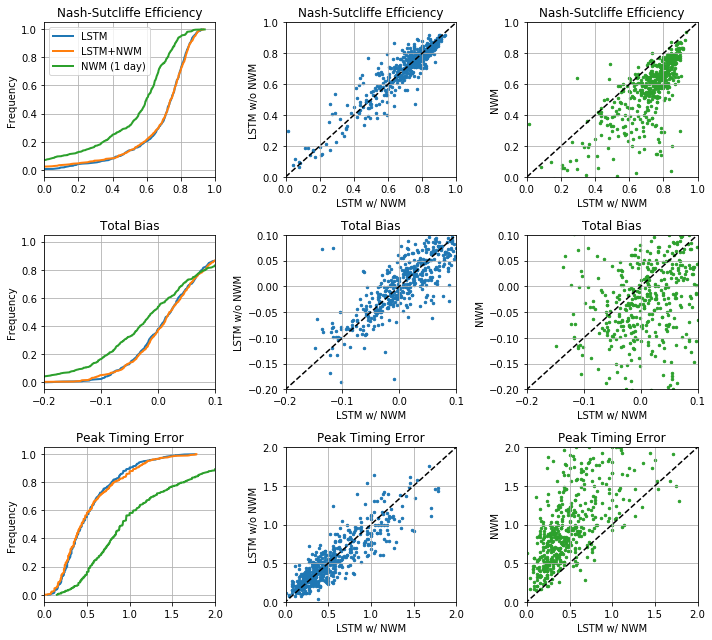

In [24]:
met_lims = [[0,1], [-5,40], [-5,10], [-1,1], [0,2], [0,1], [-.2,.1],[-50,50], [],[],[],[0,2]]
metric_names = ['Nash-Sutcliffe Efficiency', 'Total Bias', 'Peak Timing Error']
plot_model_names = ['LSTM', 'LSTM+NWM', 'NWM (1 day)']
yvalues = list(range(len(basin_list)))
for i, _ in enumerate(yvalues):
    yvalues[i] = yvalues[i]/len(yvalues)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(3,3, figsize=(10,9))

for imet, nmet in enumerate([0,6,11]):
    met_name = mets[imet]
    x_lim_imet = met_lims[imet]
    x = [np.array(ensemble_metric_dictionary['v0'][:,nmet]),
         np.array(ensemble_metric_dictionary['v2'][:,nmet]),
         np.array(ensemble_metric_dictionary['nwm'][:,nmet])]
    for imod,X in enumerate(x):
        plotdata = X
        plotdata = np.sort(plotdata[~pd.isnull(plotdata)])
        axes[imet,0].plot(plotdata,  yvalues[:len(plotdata)], label=plot_model_names[imod], lw=2)
        axes[imet,0].grid()
        axes[imet,0].set_xlim(list(met_lims[nmet]))
        axes[imet,0].set_title(metric_names[imet])
        axes[imet,0].set_ylabel('Frequency')

    ydata = x[0]
    xdata = x[1]
    axes[imet,1].plot(list(met_lims[imet]), list(met_lims[imet]), 'k--')
    axes[imet,1].scatter(xdata,  ydata, label=plot_model_names[imod], marker='o', s=6, c=cycle[0])
    axes[imet,1].grid()
    axes[imet,1].set_xlim(list(met_lims[nmet]))
    axes[imet,1].set_ylim(list(met_lims[nmet]))
    axes[imet,1].set_title(metric_names[imet])
    axes[imet,1].set_ylabel('LSTM w/o NWM')
    axes[imet,1].set_xlabel('LSTM w/ NWM')

    ydata = x[2]
    xdata = x[1]
    axes[imet,2].plot(list(met_lims[imet]), list(met_lims[imet]), 'k--')
    axes[imet,2].scatter(xdata,  ydata, label=plot_model_names[imod], marker='o', s=6, c=cycle[2])
    axes[imet,2].grid()
    axes[imet,2].set_xlim(list(met_lims[nmet]))
    axes[imet,2].set_ylim(list(met_lims[nmet]))
    axes[imet,2].set_title(metric_names[imet])
    axes[imet,2].set_ylabel('NWM')
    axes[imet,2].set_xlabel('LSTM w/ NWM')
        
axes[0,0].legend()
fig.tight_layout() 

# Plot the change in performance on a map

In [30]:
plot_lats = []
plot_lons = []
for i, b in enumerate(basin_list):
    plot_lats.append(attributes.loc[int(b),'gauge_lat'])
    plot_lons.append(attributes.loc[int(b),'gauge_lon'])
plot_lats = np.array(plot_lats)
plot_lons = np.array(plot_lons)

In [128]:
# spatial plot of improvements
bounds = [(-0,1), (-0.2,0.1), (0,2)]
diff_bounds = [1, 0.2, 2]
optimal = [1, 0, 0]
use_metrics = ['NSE', 'Beta-NSE', 'Peak-Timing']
use_metric_locs = [0,6,11]
use_metric_names = ['Nash-Sutcliffe Efficiency', 'Total Bias', 'Peak Timing Error']
plot_models = ['control', 'test', 'NWM_all_forcings']
display_model_names = {'v0':'LSTM w/o NWM', 'v2':'LSTM w NWM', 'nwm':'NWM (1 day)'}
display_colors_from_control = {'nwm':'PRGn', 'v0':'PuOr'}
display_bounds_from_control = {'nwm':[(-0,1), (-0.2,0.1), (0,2)], 'v0':[(-0,1), (-0.2,0.1), (0,2)]}

In [129]:
def PERFORMANCE_IMPROVEMENTS(control, test, percent=False):
    improvement = np.full([len(basin_list),len(use_metrics)], np.nan)
    percent_improvement = np.full([len(basin_list),len(use_metrics)], np.nan)
    for m, metric in enumerate(use_metrics):
        imet=use_metric_locs[m]
        if optimal[m] == 1:
            improvement[:,m] = ensemble_metric_dictionary[test][:,imet] - \
                               ensemble_metric_dictionary[control][:,imet]
            percent_improvement[:,m] = improvement[:,m] / np.abs(ensemble_metric_dictionary[control][:,imet])
        elif optimal[m] == 0:
            improvement[:,m] = np.abs(ensemble_metric_dictionary[control][:,imet]) - \
                                np.abs(ensemble_metric_dictionary[test][:,imet])
            percent_improvement[:,m] = improvement[:,m] / np.abs(ensemble_metric_dictionary[control][:,imet])
    if percent:
        return percent_improvement
    else:
        return improvement

In [138]:
def COUNT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, threshold=1, verbose=True):
    for m, metric in enumerate(use_metrics):
        count_improved = 0
        count_detriment = 0
        count_total = 0
        imet=use_metric_locs[m]
        for i, ival in enumerate(improvement[:,m]):
            if ensemble_metric_dictionary['nwm'][i,0] < threshold:
                count_total += 1
                if ival > 0:
                    count_improved+= 1
                if ival < 0:
                    count_detriment+= 1
        if verbose:
            print(metric)
            print('Number of improved basins = {}, {:.2f}%'.format(count_improved, 
                                                                   count_improved/count_total))
            print('Number of detrimented basins = {}, {:.2f}%'.format(count_detriment, 
                                                                      count_detriment/count_total))
        else:
            if metric == 'NSE':
                return count_improved/count_total

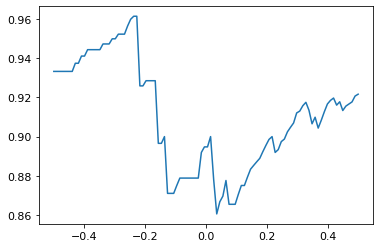

In [139]:
# Checking to see if we set a threshold for NWM performance quality, could we strategically improve the 
# performance in certain basins. Looks like the answer is no.
control='nwm'
test='v2'
improvement = PERFORMANCE_IMPROVEMENTS(control, test)
percent_improved=[]
threshold_line = np.linspace(-.5, .5, num=100)
for thrs in threshold_line:
    P_I = COUNT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, threshold=thrs, verbose=False)
    percent_improved.append(P_I)
plt.plot(threshold_line, percent_improved)

In [145]:
def PLOT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, percent=False):
    
    bound = display_bounds_from_control[control]
    
    fig = plt.figure(figsize=(10, 9))
    gs = fig.add_gridspec(len(use_metrics),3)

    for m, metric in enumerate(use_metrics):

        imet=use_metric_locs[m]

        ax0 = fig.add_subplot(gs[m,:2])
        im = ax0.scatter(plot_lons, plot_lats,
                        c=improvement[:,m],
                        s=20,
                        cmap=display_colors_from_control[control],
                        vmin=-diff_bounds[m], vmax=diff_bounds[m])
        ax0.set_title(use_metric_names[m])
        clims = im.get_clim()

        # colorbar
        divider = make_axes_locatable(ax0)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

        ax1 = fig.add_subplot(gs[m,2])    
        ax1.plot(bounds[m], bounds[m], 'k--', lw=0.6)
        for b, basin in enumerate(basin_list):
            basin_color = im.to_rgba(improvement[b,m])
            ax1.scatter(ensemble_metric_dictionary[control][b,imet], 
                        ensemble_metric_dictionary[test][b,imet],
                        s=5,
                        color=im.to_rgba(improvement[b,m]))
        ax1.set_xlabel(display_model_names[control])
        ax1.set_ylabel(display_model_names[test])
        ax1.set_xlim(bounds[m])
        ax1.set_ylim(bounds[m])
        ax1.grid()

    plt.tight_layout()

NSE
Number of improved basins = 490, 0.92%
Number of detrimented basins = 41, 0.08%
Beta-NSE
Number of improved basins = 338, 0.64%
Number of detrimented basins = 193, 0.36%
Peak-Timing
Number of improved basins = 500, 0.94%
Number of detrimented basins = 24, 0.05%


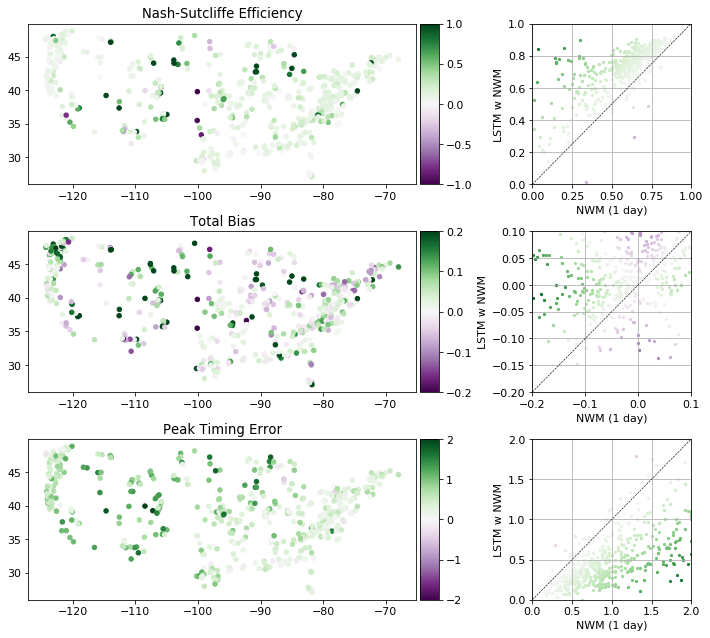

In [146]:
control='nwm'
test='v2'
improvement = PERFORMANCE_IMPROVEMENTS(control, test, percent=False)
PLOT_PERFORMANCE_IMPROVEMENTS(improvement, control, test)
COUNT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, verbose=True)

NSE
Number of improved basins = 287, 0.54%
Number of detrimented basins = 244, 0.46%
Beta-NSE
Number of improved basins = 269, 0.51%
Number of detrimented basins = 262, 0.49%
Peak-Timing
Number of improved basins = 245, 0.46%
Number of detrimented basins = 224, 0.42%


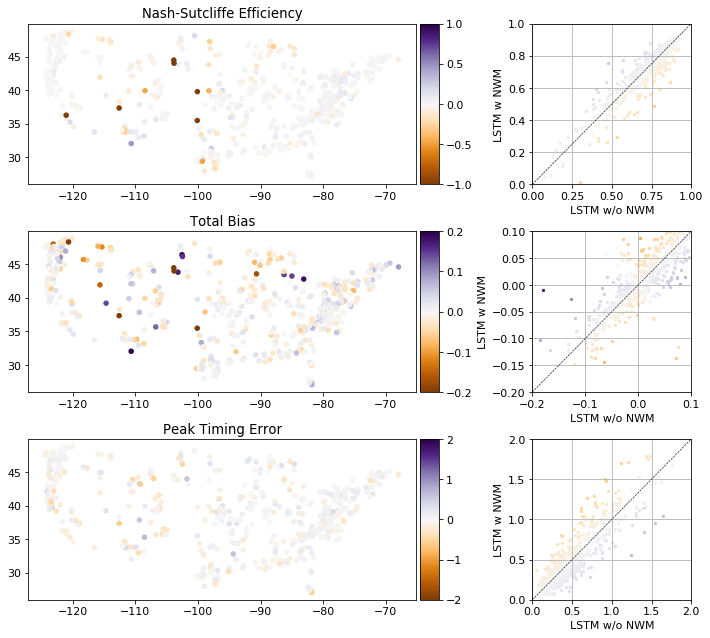

In [147]:
control='v0'
test='v2'
improvement = PERFORMANCE_IMPROVEMENTS(control, test, percent=False)
PLOT_PERFORMANCE_IMPROVEMENTS(improvement, control, test)
COUNT_PERFORMANCE_IMPROVEMENTS(improvement, control, test, verbose=True)

# Performance metrics for the NWM and the LSTM, LSTM Post Processor

In [109]:
# Get the days of the record that correspond to each flow type, for each basin.
flow_categories = ['all', 'rise', 'fall','above_mean', 'below_mean',
                       'above_mid', 'below_mid', 'below_20', 'above_80']
calculate_flow_categories = False
if calculate_flow_categories:
    flow_dates = {fc:{b:[] for b in basin_list} for fc in flow_categories}

    for ib, b in enumerate(basin_list):  
        df = lstm_sample[b]

        for i_date, today in enumerate(date_range):
            # For a baseline also evaluate the whole record
            flow_dates['all'][b].append(today)

            # Rising and falling limbs
            if i_date>0:
                yesterday =  date_range[i_date-1]
                diff_1d = df.loc[today,'qobs']-df.loc[yesterday,'qobs']
                if diff_1d < 0:
                    flow_dates['fall'][b].append(today)
                if diff_1d > 0:
                    flow_dates['rise'][b].append(today)

            # Above or below Median
            if df.loc[today,'qobs'] > np.median(df.loc[:,'qobs']):
                flow_dates['above_mid'][b].append(today)
            else:
                flow_dates['below_mid'][b].append(today)

            # Above or below Mean
            if df.loc[today,'qobs'] > np.mean(df.loc[:,'qobs']):
                flow_dates['above_mean'][b].append(today)
            else:
                flow_dates['below_mean'][b].append(today)

            # Above or below 20th/80th percentile
            if df.loc[today,'qobs'] > np.percentile(df.loc[:,'qobs'], 80):
                flow_dates['above_80'][b].append(today)
            elif df.loc[today,'qobs'] < np.percentile(df.loc[:,'qobs'], 20):
                flow_dates['below_20'][b].append(today) 
        # Save values to pickle file
        with open(data_dir+'flow_category_dates.p','wb') as f:
            pkl.dump(flow_dates, f)
else:
    with open(data_dir+'flow_category_dates.p','rb') as f:
        flow_dates = pkl.load(f)

In [110]:
def calc_nse(obs, sim):
    diff1 = obs - sim
    diff2 = obs - np.mean(obs)
    numer = np.nanmean(np.power(diff1,2))
    denom = np.nanmean(np.power(diff2,2))
    return 1-numer/denom
def calc_bias(obs, sim):
    sum_obs = np.sum(obs)
    sum_sim = np.sum(sim)
    return sum_obs - sum_sim
def calc_beta_nse(obs, sim):
    return float((sim.mean() - obs.mean()) / obs.std())
def calc_alpha_nse(obs, sim):
    return float(sim.std() / obs.std())

In [111]:
# Get all the metrics available in one list.
obs_model_types = ['obs', 'nwm', 'v0', 'v2']

met_mat = {fc:np.full([nbasins,3,nmets],np.nan) for fc in flow_categories}

flow_mat = {fc:{mt:[] for mt in obs_model_types} for fc in flow_categories}

did_not_calculate = []

# Loop through the basins and calculate the performance metric.
for ib, b in enumerate(basin_list):  
    # Keep a record of any infinities that come out of performance metric calculations.
    basin_inf = {fc:[] for fc in ['nwm', 'v0', 'v2']}

    # Loop through the flow categories, and calculate the performance metrics.
    # Any flow category that is split up by percentile 
    for fc in flow_categories:
        # But some of the metrics do not make sense when the flow is split up by category
        #             i.e., the timing metrics don't make sense without consecutive days.
        if fc != flow_categories[0]:
            loop_mets = mets[0:7]
        else:
            loop_mets = mets
            
        flow_set = flow_dates[fc][b]

        xobs = xr.DataArray(lstm_sample[b].loc[flow_set, 'qobs']).rename({'dim_0': 'date'})
        flow_mat[fc]['obs'].extend(list(lstm_sample[b].loc[flow_set,'qobs']))
        
        # Do not calculate the metrics on the basins that have a mean close to zero.
        # This will lead to -inf or very low (-100xxx) Nash-Sutcliffe values.
        if np.mean(lstm_sample[b].loc[flow_set, 'qobs']) > 0:
            is_calc_metrics = True
        else:
            is_calc_metrics = False
            did_not_calculate.append([b,fc])
        
        # 1) combined flows from all basins into one dictionary, for overall metrics
        # 2) Calculate the metrics for each model type.
        for imt, model_type in enumerate(['nwm', 'v0','v2']):
            # Combine all the basins so the metrics can be calculated across them all at once.
            flow_mat[fc][model_type].extend(list(ensemble_q_dictionary[model_type][b].loc[flow_set]))
            # Now just put the curent basin's flow into an xarray to get the metrics for this basin alone.
            xsim = xr.DataArray(ensemble_q_dictionary[model_type][b].loc[flow_set]).rename({'dim_0': 'date'})
            if is_calc_metrics:
                met_dict = metrics.calculate_metrics(xobs, xsim, loop_mets)
                for imet, met_name in enumerate(loop_mets):
                    if np.isinf(met_dict[met_name]):
                            basin_inf[model_type].append([b, met_name])
                    met_mat[fc][ib,imt,imet] = met_dict[met_name]
else:    
    with open(data_dir+'flow_category_dates.p','rb') as f:
        flow_dates = pkl.load(f)

In [112]:
model_types = ['nwm', 'v0', 'v2']
model_types2 = ['NWM', 'LSTM', 'LSTM+NWM']
combined_metric_list = ['nse', 'bias', 'variance', 'pearsonr']
combined_metric_results={fr:pd.DataFrame(index=model_types2, columns=combined_metric_list) 
                         for fr in flow_categories}
for fc in flow_categories:
    for imodel, model_name in enumerate(model_types):
        obs = np.array(flow_mat[fc]['obs'])
        sim = np.array(flow_mat[fc][model_name])
        combined_metric_results[fc].loc[model_types2[imodel],'nse']=calc_nse(obs,sim)
        combined_metric_results[fc].loc[model_types2[imodel],'bias']=calc_beta_nse(obs,sim)
        combined_metric_results[fc].loc[model_types2[imodel],'variance']=calc_alpha_nse(obs,sim)
        combined_metric_results[fc].loc[model_types2[imodel],'pearsonr'], _ = st.pearsonr(obs,sim)
combined_metric_results

{'all':                nse       bias  variance  pearsonr
 NWM       0.736095 -0.0184863  0.845098   0.85826
 LSTM      0.817066  0.0106489  0.890467  0.904082
 LSTM+NWM  0.822149   0.015171  0.924919  0.907028,
 'rise':                nse        bias  variance  pearsonr
 NWM       0.705659  -0.0728833  0.775065  0.846185
 LSTM       0.78055 -0.00836049  0.846208   0.88435
 LSTM+NWM   0.78943 -0.00112685  0.890064  0.888501,
 'fall':                nse       bias  variance  pearsonr
 NWM        0.77081  0.0213339  0.966356  0.882236
 LSTM      0.868992  0.0260437  0.961617     0.933
 LSTM+NWM  0.867573  0.0300268  0.981205  0.933158,
 'above_mean':                nse       bias  variance  pearsonr
 NWM        0.67248  -0.089972  0.832749  0.825006
 LSTM      0.775032 -0.0440824  0.867586  0.881573
 LSTM+NWM  0.781253 -0.0290019  0.907283   0.88465,
 'below_mean':                nse      bias variance  pearsonr
 NWM       0.588838  0.117495   1.1309  0.831895
 LSTM      0.676429  0.1706

In [113]:
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('expand_frame_repr', False)
for fc in flow_categories:
    print(fc)
    G = [np.nanmean(met_mat[fc][:,0,0]), 
         np.nanmean(met_mat[fc][:,1,0]), 
         np.nanmean(met_mat[fc][:,2,0])]
    H = [np.nanmedian(met_mat[fc][:,0,0]), 
         np.nanmedian(met_mat[fc][:,1,0]), 
         np.nanmedian(met_mat[fc][:,2,0])]
    I = [np.nanmedian(met_mat[fc][:,0,3]), 
         np.nanmedian(met_mat[fc][:,1,3]), 
         np.nanmedian(met_mat[fc][:,2,3])]
    J = [np.nanmedian(met_mat[fc][:,0,4]), 
         np.nanmedian(met_mat[fc][:,1,4]), 
         np.nanmedian(met_mat[fc][:,2,4])]
    K = [np.nanmedian(met_mat[fc][:,0,6]), 
         np.nanmedian(met_mat[fc][:,1,6]), 
         np.nanmedian(met_mat[fc][:,2,6])]
    L = [np.nanmedian(met_mat[fc][:,0,5]), 
         np.nanmedian(met_mat[fc][:,1,5]), 
         np.nanmedian(met_mat[fc][:,2,5])]
    M = [np.nanmedian(met_mat[fc][:,0,11]), 
         np.nanmedian(met_mat[fc][:,1,11]), 
         np.nanmedian(met_mat[fc][:,2,11])]
    df = pd.DataFrame(data=np.array([G, H, I, J, K, L, M]).reshape(7,3).transpose(),
                      index=['NWM', 'LSTM', 'LSTM+NWM'],  
            columns=['NSE(mean)','NSE(median)','KGE','Alpha-NSE','Beta-NSE','Pearsonr','PeakTiming'])
    print(df)

all
          NSE(mean)  NSE(median)     KGE  Alpha-NSE  Beta-NSE  Pearsonr  PeakTiming
NWM         0.43963      0.59758 0.63780    0.82595  -0.00928   0.80351     0.92000
LSTM        0.68626      0.74276 0.74285    0.83370   0.02226   0.87748     0.44000
LSTM+NWM    0.66197      0.73972 0.75812    0.87329   0.01977   0.87734     0.44000
rise
          NSE(mean)  NSE(median)     KGE  Alpha-NSE  Beta-NSE  Pearsonr  PeakTiming
NWM         0.46178      0.57910 0.55436    0.72683  -0.09009   0.80476         nan
LSTM        0.66099      0.71130 0.72147    0.80490  -0.00804   0.86315         nan
LSTM+NWM    0.64369      0.72087 0.73557    0.84914   0.00514   0.86707         nan
fall
          NSE(mean)  NSE(median)     KGE  Alpha-NSE  Beta-NSE  Pearsonr  PeakTiming
NWM         0.22884      0.57091 0.63907    1.03278   0.06053   0.83316         nan
LSTM        0.68784      0.77903 0.77222    0.92292   0.04980   0.90196         nan
LSTM+NWM    0.61107      0.76755 0.76523    0.94268   0.05166 

/home/jmframe/programs/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


# Calculate the hydrologic signatures for all the models and oberservation

In [114]:
# Calculate the hydrologic signatures for all the models, and see which is closer to the observation.
sigs = signatures.get_available_signatures()
nsigs = len(sigs)
sigs_dict = {imod:pd.DataFrame(index=basin_list, data=np.full([nbasins,nsigs],np.nan), columns=sigs) \
             for imod in obs_model_types}

for root, subdirs, files in os.walk(nldas_dir):
    for file in files:
        file_path = os.path.join(root, file)
        b = file[0:8]
        if b not in flow_dates['all'].keys():
            continue
        flow_set = flow_dates['all'][b]
        hu = attributes.loc[int(b), 'basin_hydro_unit']
        with open(file_path, 'r') as f:
            df = pd.read_csv(f, sep="\s+",header=3)
        dti = pd.date_range('1980-01-01', periods=df.shape[0], freq='D')
        df['date'] = dti
        df = df.set_index('date')
        prcp=xr.DataArray(df['PRCP(mm/day)'])

        for imt, model_type in enumerate(['nwm', 'v0','v2']):
            xsim = xr.DataArray(ensemble_q_dictionary[model_type][b].loc[flow_set]).rename({'dim_0': 'date'})
            sigs_dict[model_type].loc[b,:] = signatures.calculate_all_signatures(da=xsim, prcp=prcp)
            
        xobs = xr.DataArray(lstm_sample[b].loc[flow_set, 'qobs']).rename({'dim_0': 'date'})
        sigs_dict['obs'].loc[b,:] = signatures.calculate_all_signatures(da=xobs, prcp=prcp)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


high_q_freq


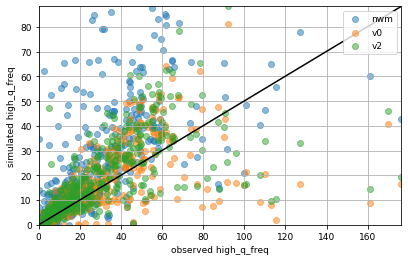

high_q_dur


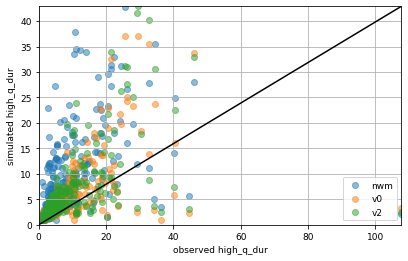

low_q_freq


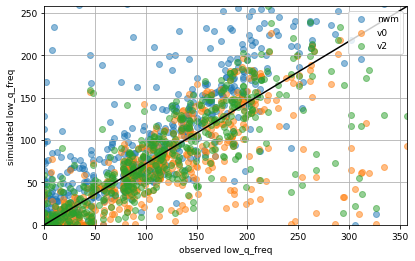

low_q_dur


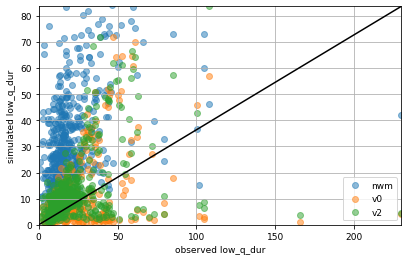

zero_q_freq


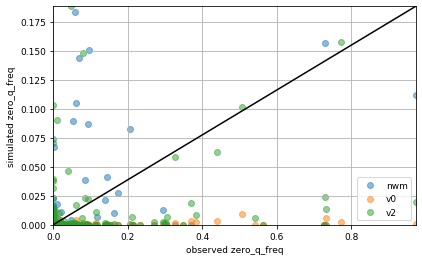

q95


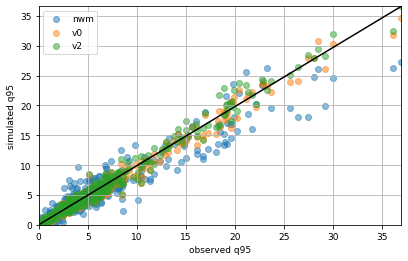

q5


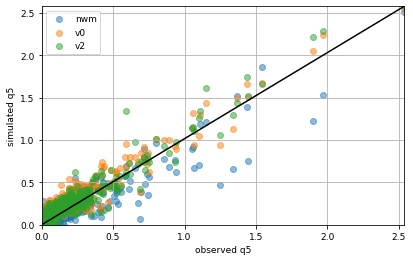

q_mean


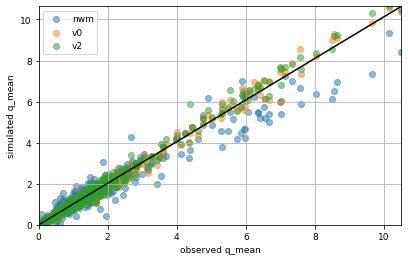

hfd_mean


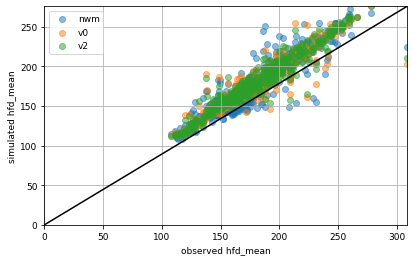

baseflow_index


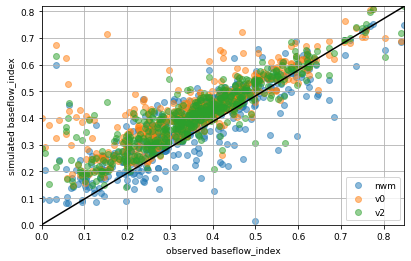

slope_fdc


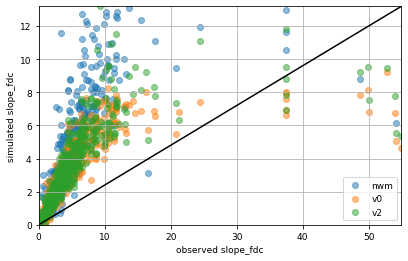

stream_elas


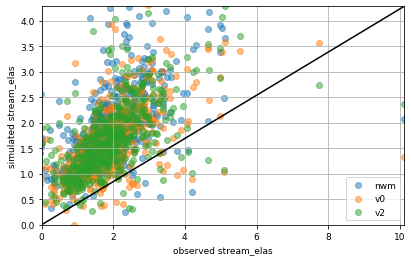

runoff_ratio


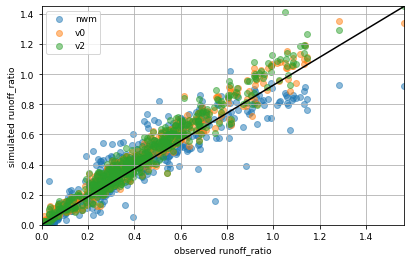

In [117]:
#RMSE Values
model_types2 = ["NWM", "LSTM", "LSTM+NWM"]

df_sigs={'rmse':pd.DataFrame(index=sigs_dict['obs'].columns.values, columns=model_types2),
         'r-squared':pd.DataFrame(index=sigs_dict['obs'].columns.values, columns=model_types2)}

for sig in sigs_dict['obs'].columns.values:
    print(sig)
    for imod, imod2 in zip(model_types, model_types2):
        df_sigs['rmse'].loc[sig,imod2] = np.log(np.sqrt(np.square(np.mean(sigs_dict['obs'].loc[:,sig] - 
                                         sigs_dict[imod].loc[:,sig]))))

    mpl.rcParams.update({'font.size': 9})
    fig, ax = plt.subplots(figsize=(6.5,4.02))
    
    for imod, imod2 in zip(model_types, model_types2):
        obs_1d = np.array(sigs_dict['obs'].loc[:,sig]).reshape(sigs_dict['obs'].loc[:,sig].shape[0],)
        sigs_1d = np.array(sigs_dict[imod].loc[:,sig]).reshape(sigs_dict[imod].loc[:,sig].shape[0],)
        df = pd.DataFrame({'obs':obs_1d, 'sig':sigs_1d})
        df = df.dropna()
        slope, intercept, r_value, p_value, std_err = st.linregress(df['obs'], df['sig'])

        df_sigs['r-squared'].loc[sig,imod2] = r_value**2

        ax.scatter(sigs_dict['obs'].loc[:,sig], sigs_dict[imod].loc[:,sig], alpha=.5, label=imod)
        plt.grid()
    
    plt.ylabel('simulated '+sig,fontname="Arial")
    plt.xlabel('observed '+sig,fontname="Arial")
    plt.plot([0,np.max(sigs_dict['obs'].loc[:,sig])],
             [0,np.max(sigs_dict[imod].loc[:,sig])], c='k')
    plt.xlim([0,np.max(sigs_dict['obs'].loc[:,sig])])
    plt.ylim([0,np.max(sigs_dict[imod].loc[:,sig])])
    plt.legend()
    plt.show()
    plt.close()

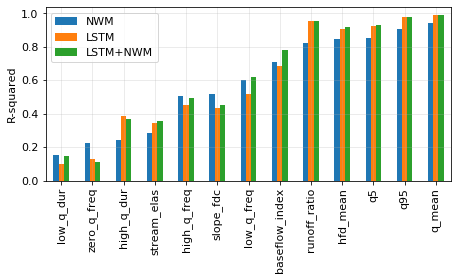

In [123]:
fig_scale=1
mpl.rcParams.update({'font.size': 11})
#fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=False, figsize=(fig_scale*6.5, fig_scale*4.02))
fig, ax0 = plt.subplots(figsize=(fig_scale*6.5, fig_scale*4.02))

df_sigs['r-squared'].sort_values('NWM').loc[:, ['NWM', 'LSTM', 'LSTM+NWM']].plot.bar(ax=ax0)
ax0.set_ylabel('R-squared')
ax0.grid(alpha=0.3)
# df_sigs['rmse'].sort_values('NWM').loc[:, ['NWM', 'LSTM', 'LSTM+NWM']].plot.bar(ax=ax1)
# ax1.set_ylabel('log of RMSE')
# ax1.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

# POST PROCESSOR PERFORMANCE REGRESSION

In [ ]:
attributes['nwm'] = [np.nan]*attributes.shape[0]
attributes['lstmnwm-nwm'] = [np.nan]*attributes.shape[0]
imet=0
r=0
plot_change = np.full([nbasins,3],np.nan)
for i, b in enumerate(basin_list):
    attributes.loc[int(b), 'nwm'] = ensemble_metric_dictionary['nwm'][i,imet]
    attributes.loc[int(b), 'lstmnwm-nwm'] = ensemble_metric_dictionary['v2'][i,imet] - \
                       ensemble_metric_dictionary['nwm'][i,imet]
# Remove any rows with nan
df = attributes.dropna()

In [ ]:
# 528 basins / 16 splits = 33 samples in each split.
n_splits = 16 

In [ ]:
# Python program to sort  
# one list using 
# the other list 
def sort_list(list1, list2): 
    zipped_pairs = zip(list2, list1) 
    z = [x for _, x in sorted(zipped_pairs)] 
    return z

In [ ]:
def print_stats(d):
    print("mean = {:.2f},  median = {:.2f}, stdev = {:.2f}, min = {:.2f}, max = {:.2f}".format(
        np.nanmean(np.array(d)),
        np.nanmedian(np.array(d)),
        np.nanstd(np.array(d)),
        np.nanmin(np.array(d)),
        np.nanmax(np.array(d))
        )
    )

In [ ]:
# Random Forest Regression in a K-fold loop
def cross_val_rf(X,y,feature_list,kf,ynormal=False,
                 n_estimators=10,random_state=42,
                 criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                 min_weight_fraction_leaf=0, feature_list_short=[]):

    if len(feature_list_short) > 1:
        index_labs = feature_list_short
    else:
        index_labs = feature_list
    feature_importances = pd.DataFrame(index=index_labs, columns=['total_importance'])
    for iF, F in enumerate(feature_importances.index.values):
        feature_importances.loc[F, 'total_importance'] = 0
    
    rmse_list = []
    r2_list = []
    y_hat_list = []
    y_hat_indx_list = []
    
    fig, ax = plt.subplots(figsize=(6.5,4.02))
    grid = plt.GridSpec(1, 3, wspace=0.33333)
    plt.subplot(grid[0, 0:2])
    for train_index, test_index in kf.split(X):
                
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state,
                                  criterion=criterion, min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split, max_depth=max_depth,
                                  min_weight_fraction_leaf=min_weight_fraction_leaf)
        rf.fit(X_train, y_train);
        y_hat = rf.predict(X_test)

        # Get numerical feature importances
        importances = list(rf.feature_importances_)
        for iF, F in enumerate(feature_importances.index.values):
            feature_importances.loc[F, 'total_importance'] += importances[iF]
        
        rmse = np.sqrt(np.mean(np.power((y_test - y_hat),2)))
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y_test, y_hat)
        r2 = r_value**2        
        plt.scatter(y_test,y_hat)
        
        rmse_list.append(rmse)
        r2_list.append(r2)
        y_hat_list.extend(y_hat)
        y_hat_indx_list.extend(test_index)
    
    feature_importances.loc[:, 'total_importance'] = feature_importances.loc[:, 'total_importance'] / \
                                                     kf.get_n_splits()

    #plt.title("Cross validation results with {:2d} splits".format(kf.get_n_splits()))
    plt.xlabel("true target values")
    plt.ylabel("predicted values")

    y_hat_all = sort_list(y_hat_list, y_hat_indx_list)
    
    overall_rmse = np.sqrt(np.mean(np.power((y - y_hat_all),2)))
    slope, intercept, overall_r_value, _, _ = scipy.stats.linregress(y, y_hat_all)
    overall_r2_value = overall_r_value**2
    print('Overall rmse for the out-of-sample predictions: {:.2f}'.format(overall_rmse))
    print('Overall r^2 for the out-of-sample predictions: {:.2f}'.format(overall_r_value**2))
    print("RMSE Value stats for cross validation")
    print_stats(rmse_list)
    print("R-squared Value stats for cross validation")
    print_stats(r2_list)
    x=np.linspace(np.min(y), np.max(y), num=2)
    omax = np.max([np.max(y), np.max(y_hat_all)])
    omin = np.min([np.min(y), np.min(y_hat_all)])
    plt.xlim([omin,omax])
    plt.ylim([omin,omax])
    plt.plot(x, x*slope+intercept)
    plt.grid()
    
    plt.subplot(grid[0, 2])
    feature_importances.sort_values('total_importance', ascending=False).plot.bar(ax = plt.gca())
    plt.legend([])
    plt.ylabel('feature importance')
    plt.xticks(rotation=90)
    plt.grid()

    grid.tight_layout(fig)
    plt.show()
    plt.close()    

    return y_hat_all, overall_rmse, overall_r2_value, feature_importances

In [ ]:
# Set the training and targets.
def set_X_y(df, regressor_attributes, target, xnormal=False, ynormal=False, xlog=False, ylog=False):
    X=np.array(df.loc[:,regressor_attributes])
    y=np.array(df[target])
    X_krig=np.array(df.loc[:,['gauge_lat', 'gauge_lon']])

    if ynormal:
        y_mean = np.nanmean(y)
        y_std = np.nanstd(y)
        y = (y-y_mean)/y_std
    
    if xnormal:
        for i, r in enumerate(regressor_attributes):
            iX = np.array(df.loc[:,r])
            X_mean = np.nanmean(iX)
            X_std = np.nanstd(iX)
            X[:,i] = (iX - X_mean) / X_std
    
    if xlog:
        for i, r in enumerate(regressor_attributes):
            for iX in range(X.shape[0]):
                if np.abs(np.log(np.array(df.iloc[iX,i]))) > 0:
                    X[iX] = np.log(np.array(df.iloc[iX,i]))
    if ylog:
        for iy in range(y.shape[0]):
            if np.abs(np.log(y[iy])) > 0:
                y[iy] = np.log(y[iy])
        
    return X, y

In [ ]:
# Make a dictionary for all the X, y values
X = {'X_krig':np.array(df.loc[:,['gauge_lat','gauge_lon']])}
y = {}
z = {}
y_hat = {}
Cross = {}

In [ ]:
#regressor_attributes = list(attributes.columns.values[0:11])
#regressor_attributes.append('nwm')
regressor_attributes = ['nwm', 'baseflow_index', 'runoff_ratio']
feature_list_short = ['nwm', 'B.I.', 'R.R.']
target='lstmnwm-nwm'
ynormal = True
X[target], y[target] = set_X_y(df, regressor_attributes, target, xnormal=True, ynormal=ynormal)

kf = KFold(n_splits=10, shuffle=True)
y_hat[target], rmse, r2, feature_importance = cross_val_rf(X[target],y[target],regressor_attributes,kf,
                ynormal=ynormal, n_estimators=1000,random_state=100,
                criterion='mse', min_samples_leaf=1, min_samples_split=2, max_depth=None,
                min_weight_fraction_leaf=0, feature_list_short=feature_list_short)